<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

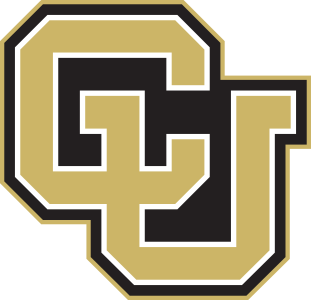

# Lecture 7, hands-on: Applying Dimensionality Reduction Techniques
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Reading Material

From the scikit-learn documentation:

* [Matrix factorization approaches](https://scikit-learn.org/stable/modules/decomposition.html) (like PCA).
* [Manifold learning](https://scikit-learn.org/stable/modules/manifold.html) (like TSNE).

# PCA In-Depth
(Adapted from [PyCon 2015 scikit-learn tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas)

**PCA** is an extremely useful linear dimensionality reduction technique.
PCA is a very powerful unsupervised method for *dimensionality reduction* in data.
It looks for directions in the data with the most variance.

Useful to explore data, visualize data, and discern relationships.

It's easiest to visualize by examining a two-dimensional dataset:

(np.float64(-2.7292712056271964),
 np.float64(2.5702744393352615),
 np.float64(-0.9326181575178751),
 np.float64(1.004413830229183))

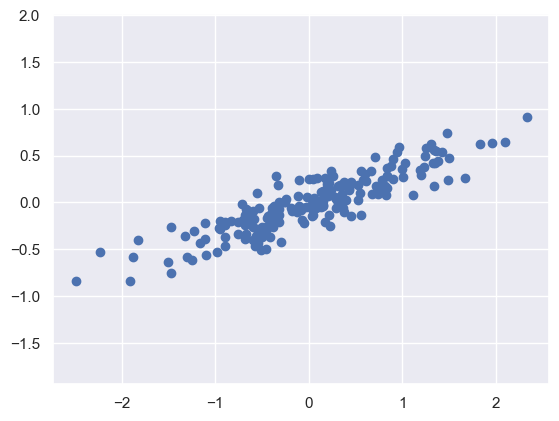

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T
plt.plot(X[:, 0], X[:, 1], "o")
plt.axis("equal")

We can see that there is a definite trend in the data. PCA seeks to find the **principal axes** in the data and explain how important those axes are in describing the data distribution:

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
print(f"Explained variance: {pca.explained_variance_}")
print(f"Explained variance (ratio): {pca.explained_variance_ratio_}")
print(f"Principal components:\n{pca.components_}")

Explained variance: [0.7625315 0.0184779]
Explained variance (ratio): [0.97634101 0.02365899]
Principal components:
[[ 0.94446029  0.32862557]
 [-0.32862557  0.94446029]]


(np.float64(-2.7527850438519383),
 np.float64(3.0640650420548505),
 np.float64(-0.9355070354017789),
 np.float64(1.0650802657911607))

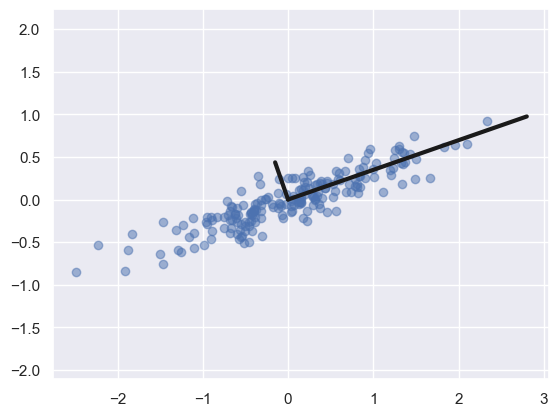

In [3]:
plt.plot(X[:, 0], X[:, 1], "o", alpha=0.5)
for length, vector in zip(pca.explained_variance_ratio_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], "-k", lw=3)
plt.axis("equal")

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction.
The explained variance quantifies this measure of "importance" in direction.

Another way to think of it is that the second principal component could be **completely ignored** without much loss of information! Let's see what our data looks like if we only keep 95% of the variance:

In [4]:
clf = PCA(n_components=0.95)  # keep 95% of variance
X_trans = clf.fit_transform(
    X
)  # this is fitting the data, and performing the "encoding" or projection of it
print(X.shape)
print(X_trans.shape)

(200, 2)
(200, 1)


See above that the explained variance ratio reaches 97% just with the first component.

By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data looks like after this compression:

In [5]:
X_new = clf.inverse_transform(X_trans)  # this does the "decoding"

In [6]:
X_new.shape

(200, 2)

In [7]:
X.shape

(200, 2)

(np.float64(-2.731158226766438),
 np.float64(2.609901883259332),
 np.float64(-0.9672765706389318),
 np.float64(1.006064230853995))

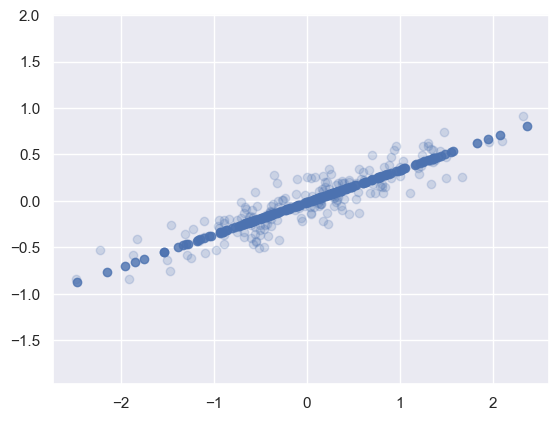

In [8]:
plt.plot(X[:, 0], X[:, 1], "o", alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], "ob", alpha=0.8)
plt.axis("equal")

The light points are the original data, while the dark points are the projected version. We see that after truncating 5% of the variance of this dataset and then reprojecting it, the "most important" features of the data are maintained, and we've compressed the data by 50%.

This is the sense in which "dimensionality reduction" works: if you can approximate a data set in a lower dimension, you can often have an easier time visualizing it or fitting complicated models to the data.

## PCA on Iris Flowers

We load the iris dataset:

In [9]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data, iris.target

In [10]:
X.shape

(150, 4)

In [11]:
y.shape

(150,)

Now, let's apply PCA to the data:

In [12]:
pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)

Reduced dataset shape: (150, 2)


<Axes: >

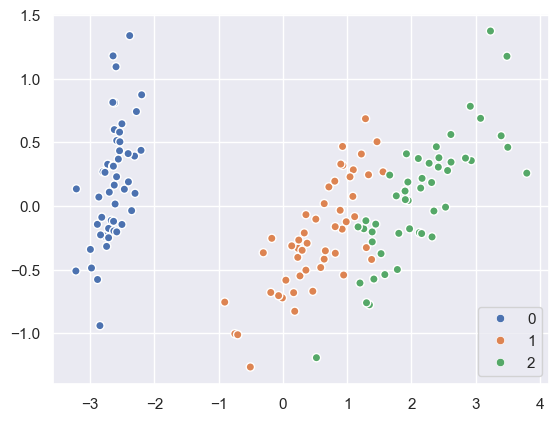

In [13]:
sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    linestyle="",
    marker="o",
    hue=y,
    palette="deep",
)

Let's see how features are combined (linearly) to create each principal component:

In [14]:
print("Meaning of the 2 components:\n")
for i, component in enumerate(pca.components_):
    print(f"PC #{i}: ", end="")
    print(
        " + ".join(
            "%.3f x %s" % (value, name)
            for value, name in zip(component, iris.feature_names)
        )
    )

Meaning of the 2 components:

PC #0: 0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
PC #1: 0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


**Question:** What does this mean?

_Answer_: These PCs describe the vectors that are fit to the data, in this case for 2 components. 

# Non-Negative Matrix Factorization (NMF or NNMF)

From the scikit-learn documentation [here](https://scikit-learn.org/dev/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf):

> NMF is an alternative approach to decomposition that assumes that the data and the components are non-negative. NMF can be plugged in instead of PCA or its variants, in the cases where the data matrix does not contain negative values.

Let's use [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) and compare the results.

In [15]:
# NMF needs the data to be non-negative
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_non_negative = scaler.fit_transform(X)

In [16]:
X_non_negative.shape

(150, 4)

In [17]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2, max_iter=1000)
nmf.fit(X_non_negative)
X_nmf_reduced = nmf.transform(X_non_negative)

In [18]:
nmf.components_

array([[1.98286363, 0.0213382 , 2.83600329, 2.87558844],
       [0.65948082, 2.40557694, 0.05534224, 0.        ]])

<Axes: >

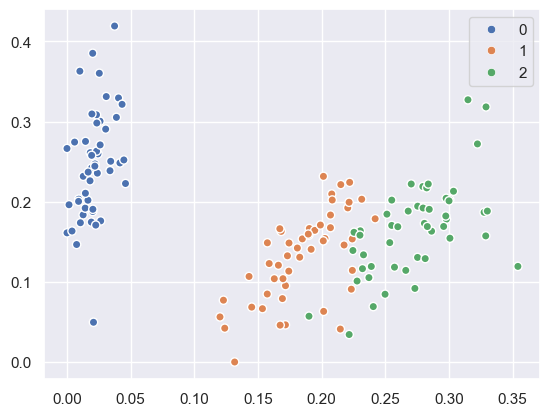

In [19]:
sns.scatterplot(
    x=X_nmf_reduced[:, 0],
    y=X_nmf_reduced[:, 1],
    linestyle="",
    marker="o",
    hue=y,
    palette="deep",
)

In [20]:
print("Meaning of the 2 components:\n")
for i, component in enumerate(nmf.components_):
    print(f"LV #{i}: ", end="")
    print(
        " + ".join(
            "%.3f x %s" % (value, name)
            for value, name in zip(component, iris.feature_names)
        )
    )

Meaning of the 2 components:

LV #0: 1.983 x sepal length (cm) + 0.021 x sepal width (cm) + 2.836 x petal length (cm) + 2.876 x petal width (cm)
LV #1: 0.659 x sepal length (cm) + 2.406 x sepal width (cm) + 0.055 x petal length (cm) + 0.000 x petal width (cm)


**Question:** How does this compare with PCA?

_Answer_: Whereas PCA contained negative estimates, NMF contains only positive estimates to describe the fit vectors.

# Dataset 1

Load dataset. Feature names have the format "f[NUMBER]". Column "labels", if present, are the true labels/clusters.

In [21]:
# load dataset
import pandas as pd

data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/8elyky9mtq9nser82xk05/dataset01.tsv?rlkey=wlue2ejkkyen8ghdxah6yqso2&st=n9x9muq9&dl=1",
    sep="\t",
)

In [22]:
data_labels = data.pop("labels")

## Exercise 1

Apply PCA and plot the projected data.

In [23]:
X = data.values

pca = PCA(n_components=2)
pca.fit(X)
X_reduced = pca.transform(X)
print("Reduced dataset shape:", X_reduced.shape)

Reduced dataset shape: (100, 2)


## Exercise 2

What happens if we apply KMeans on the PCA projection of this data? This is what you did in lecture 3's hands-on exercise (code below for your convenience).

Complete the code below and run it.

In [ ]:
# Change the code below to use the PCA projected data
X = np.array([])

In [ ]:
from scipy.spatial.distance import pdist
from sklearn import cluster
from sklearn.metrics import adjusted_rand_score as ari

np.random.seed(0)

Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")

**Question:** how does this compare with your solution from the lecture03's hands-on exercise?

## Exercise 3

What do the principal components mean? How are original features combined by PCA?

In [ ]:
# add code

**Question:** Does NMF help improve interpretation?

## Exercise 4: Incremental PCA

From the scikit-learn documentation:

> Incremental principal component analysis (IPCA) is typically used as a replacement for principal component analysis (PCA) when the dataset to be decomposed is too large to fit in memory.

Use [Incremental PCA](https://scikit-learn.org/dev/auto_examples/decomposition/plot_incremental_pca.html) and compare the results.

In [ ]:
# add code

# Dataset 2

In [ ]:
from sklearn.datasets import make_circles

data, data_labels = make_circles(
    n_samples=1_000, factor=0.3, noise=0.05, random_state=0
)

In [ ]:
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=data_labels)

## Exercise 5

Apply PCA and plot the projected data.

In [ ]:
# add code

**Question:** What is going to happen if we apply Logistic Regression to predict the labels in the PCA projection? Is it going to help us?

In [ ]:
# add code

## Exercise 6

**Question:** Would MDS or TSNE help us in the previous prediction problem with Logistic Regression?

In [ ]:
# add code

## Exercise 7: Kernel PCA

**Question:** Would KernelPCA help us in the previous prediction problem with Logistic Regression?

*Tip:* Look at the [KernelPCA guide](https://scikit-learn.org/dev/modules/decomposition.html#kernel-principal-component-analysis-kpca) and try a `gamma` value larger than 1.0 (default).

In [ ]:
# add code

# Dataset 3: Handwritten Digits
(Adapted from scikit-learn guide [here](https://scikit-learn.org/dev/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py))

Load the digits dataset and plot some examples:

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

This is a helper function to visualize results:

In [ ]:
# Helper function to plot embedding
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

## Exercise 8

Apply PCA, MDS, and TSNE to this data: `X` and `y`. Which one seems to do better?

In [ ]:
# add code